## Chebyshev2-KAN for MNIST

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from Cheby2KANLayer import Cheby2KANLayer

In [5]:
# Construct a Cheby2KAN for MNIST
class MNISTCheby2KAN(nn.Module):
    def __init__(self):
        super(MNISTCheby2KAN, self).__init__()
        self.cheby2kan1 = Cheby2KANLayer(28*28, 32, 4)
        self.ln1 = nn.LayerNorm(32) # To avoid gradient vanishing caused by tanh
        self.cheby2kan2 = Cheby2KANLayer(32, 16, 4)
        self.ln2 = nn.LayerNorm(16)
        self.cheby2kan3 = Cheby2KANLayer(16, 10, 4)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.cheby2kan1(x)
        x = self.ln1(x)
        x = self.cheby2kan2(x)
        x = self.ln2(x)
        x = self.cheby2kan3(x)
        return x

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNISTCheby2KAN().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

criterion = nn.CrossEntropyLoss()

# LBFGS is really slow
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Adam works with very low lr
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        if isinstance(optimizer, optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            
        total_loss += loss
        
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

Total trainable parameters: 128896


Epoch 1, Train Loss: 0.6500, Test Loss: 0.2247, Test Acc: 0.94
Epoch 2, Train Loss: 0.1948, Test Loss: 0.1781, Test Acc: 0.95
Epoch 3, Train Loss: 0.1410, Test Loss: 0.1578, Test Acc: 0.95
Epoch 4, Train Loss: 0.1158, Test Loss: 0.1317, Test Acc: 0.96
Epoch 5, Train Loss: 0.0984, Test Loss: 0.1279, Test Acc: 0.96
Epoch 6, Train Loss: 0.0852, Test Loss: 0.1130, Test Acc: 0.97
Epoch 7, Train Loss: 0.0755, Test Loss: 0.1136, Test Acc: 0.97
Epoch 8, Train Loss: 0.0691, Test Loss: 0.1030, Test Acc: 0.97
Epoch 9, Train Loss: 0.0621, Test Loss: 0.1304, Test Acc: 0.96
Epoch 10, Train Loss: 0.0542, Test Loss: 0.1007, Test Acc: 0.97
Epoch 11, Train Loss: 0.0522, Test Loss: 0.0947, Test Acc: 0.97
Epoch 12, Train Loss: 0.0471, Test Loss: 0.0975, Test Acc: 0.97
Epoch 13, Train Loss: 0.0408, Test Loss: 0.1095, Test Acc: 0.97
Epoch 14, Train Loss: 0.0382, Test Loss: 0.1057, Test Acc: 0.97
Epoch 15, Train Loss: 0.0385, Test Loss: 0.1013, Test Acc: 0.97
Epoch 16, Train Loss: 0.0312, Test Loss: 0.1000, 

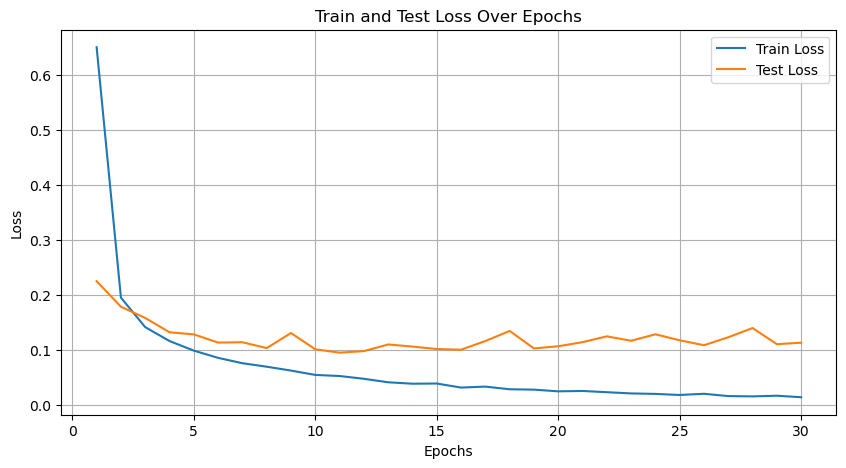

In [7]:
train_losses = []
test_losses = []

epochs = 30
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Take a peek at what the Chebyshev2 Polynomials look like

In [8]:
def chebyshev2_polynomials(x, degree):
    # T_0(x) and T_1(x)
    if degree == 0:
        return np.ones_like(x)
    elif degree == 1:
        return x
    else:
        Tn_2 = np.ones_like(x)
        Tn_1 = 2*x
        Tn = None
        for n in range(2, degree + 1):
            Tn = 2 * x * Tn_1 - Tn_2
            Tn_2, Tn_1 = Tn_1, Tn
        return Tn

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.cheby2kan1.cheby2_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[28 * 28 // 2]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * chebyshev2_polynomials(x_values, i)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Chebyshev2 Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

AttributeError: 'Cheby2KANLayer' object has no attribute 'cheby2_coeffs'

<Figure size 800x400 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.cheby2kan2.cheby2_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[16]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * chebyshev2_polynomials(x_values, i)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Chebyshev2 Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.cheby2kan3.cheby2_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[8]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * chebyshev2_polynomials(x_values, i)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Chebyshev2 Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()